In [1]:
import os
import sys
import copy

import numpy as np
import yt
from yt.frontends.ramses.field_handlers import RTFieldFileHandler

from emission import EmissionLineInterpolator
import galaxy_visualization

In [2]:
filename = "/Users/lamoreau/python/ASpec/SimulationFiles/output_00273/info_00273.txt"

lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A",
       "O3_1660.81A","O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", 
       "He2_1640.41A","C2_1335.66A","C3_1906.68A","C3_1908.73A","C4_1549.00A",
       "Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A","Ne3_3967.47A",
       "N5_1238.82A",
       "N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"]

wavelengths=[6562.80, 1304.86, 6300.30, 3728.80, 3726.10, 1660.81, 1666.15,
             4363.21, 4958.91, 5006.84, 1640.41, 1335.66,
             1906.68, 1908.73, 1549.00, 2795.53, 2802.71, 3868.76,
             3967.47, 1238.82, 1242.80, 1486.50, 1749.67, 6716.44, 6730.82]

cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]

epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]

# Ionization Parameter Field
# Based on photon densities in bins 2-4
# Don't include bin 1 -> Lyman Werner non-ionizing
def _ion_param(field, data):
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c = 2.99792458e10     #light velocity

    # Convert to physical photon number density in cm^-3
    pd_2 = data['ramses-rt','Photon_density_2']*p["unit_pf"]/cgs_c
    pd_3 = data['ramses-rt','Photon_density_3']*p["unit_pf"]/cgs_c
    pd_4 = data['ramses-rt','Photon_density_4']*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']


def _my_temperature(field, data):
    #y(i): abundance per hydrogen atom
    XH_RAMSES=0.76 #defined by RAMSES in cooling_module.f90
    YHE_RAMSES=0.24 #defined by RAMSES in cooling_module.f90
    mH_RAMSES=yt.YTArray(1.6600000e-24,"g") #defined by RAMSES in cooling_module.f90
    kB_RAMSES=yt.YTArray(1.3806200e-16,"erg/K") #defined by RAMSES in cooling_module.f90

    dn=data["ramses","Density"].in_cgs()
    pr=data["ramses","Pressure"].in_cgs()
    yHI=data["ramses","xHI"]
    yHII=data["ramses","xHII"]
    yHe = YHE_RAMSES*0.25/XH_RAMSES
    yHeII=data["ramses","xHeII"]*yHe
    yHeIII=data["ramses","xHeIII"]*yHe
    yH2=1.-yHI-yHII
    yel=yHII+yHeII+2*yHeIII
    mu=(yHI+yHII+2.*yH2 + 4.*yHe) / (yHI+yHII+yH2 + yHe + yel)
    return pr/dn * mu * mH_RAMSES / kB_RAMSES


# TODO see if it works in emission.py
# Luminosity field
# Cloudy Intensity obtained assuming height = 1cm
# Return intensity values erg/s/cm**2
# Multiply intensity at each pixel by volume of pixel -> luminosity
def get_luminosity(line):
   def _luminosity(field, data):
      return data['gas', 'flux_' + line]*data['gas', 'volume']
   return copy.deepcopy(_luminosity)


#number density of hydrogen atoms
def _my_H_nuclei_density(field, data):
    dn=data["ramses","Density"].in_cgs()
    XH_RAMSES=0.76 #defined by RAMSES in cooling_module.f90
    YHE_RAMSES=0.24 #defined by RAMSES in cooling_module.f90
    mH_RAMSES=yt.YTArray(1.6600000e-24,"g") #defined by RAMSES in cooling_module.f90

    return dn*XH_RAMSES/mH_RAMSES


def _pressure(field, data):
    if 'hydro_thermal_pressure' in dir(ds.fields.ramses): # and 
        #'Pressure' not in dir(ds.fields.ramses):
        return data['ramses', 'hydro_thermal_pressure']


def _xHI(field, data):
    if 'hydro_xHI' in dir(ds.fields.ramses): # and \
        #'xHI' not in dir(ds.fields.ramses):
        return data['ramses', 'hydro_xHI']


def _xHII(field, data):
    if 'hydro_xHII' in dir(ds.fields.ramses): # and \
        #'xHII' not in dir(ds.fields.ramses):
        return data['ramses', 'hydro_xHII']


def _xHeII(field, data):
    if 'hydro_xHeII' in dir(ds.fields.ramses): # and \
        #'xHeII' not in dir(ds.fields.ramses):
        return data['ramses', 'hydro_xHeII']


def _xHeIII(field, data):
    if 'hydro_xHeIII' in dir(ds.fields.ramses): # and \
        #'xHeIII' not in dir(ds.fields.ramses):
        return data['ramses', 'hydro_xHeIII']


In [3]:
'''
-------------------------------------------------------------------------------
Load Simulation Data
Add Derived Fields
-------------------------------------------------------------------------------
'''

ds = yt.load(filename, extra_particle_fields=epf)

ds.add_field(
    ("gas","number_density"),
    function=_my_H_nuclei_density,
    sampling_type="cell",
    units="1/cm**3",
    force_override=True
)


ds.add_field(
    ("ramses","Pressure"),
    function=_pressure,
    sampling_type="cell",
    units="1",
    #force_override=True
)

ds.add_field(
    ("ramses","xHI"),
    function=_xHI,
    sampling_type="cell",
    units="1",
    #force_override=True
)

ds.add_field(
    ("ramses","xHII"),
    function=_xHII,
    sampling_type="cell",
    units="1",
    #force_override=True
)

ds.add_field(
    ("ramses","xHeII"),
    function=_xHeII,
    sampling_type="cell",
    units="1",
    #force_override=True
)

ds.add_field(
    ("ramses","xHeIII"),
    function=_xHeIII,
    sampling_type="cell",
    units="1",
    #force_override=True
)

ds.add_field(
    ("gas","my_temperature"),
    function=_my_temperature,
    sampling_type="cell",
    # TODO units
    #units="K",
    #units="K*cm**3/erg",
    units='K*cm*dyn/erg',
    force_override=True
)

# Ionization parameter
ds.add_field(
    ('gas', 'ion_param'),
    function=_ion_param,
    sampling_type="cell",
    units="cm**3",
    force_override=True
)

ds.add_field(
    ("gas","my_H_nuclei_density"),
    function=_my_H_nuclei_density,
    sampling_type="cell",
    units="1/cm**3",
    force_override=True
)

# Normalize by Density Squared Flag
dens_normalized = True
if dens_normalized: 
    units = '1/cm**6'
else:
    units = '1'

# Instance of EmissionLineInterpolator for line list at filename
line_list = os.path.join(os.getcwd(), 'linelist.dat')
emission_interpolator = EmissionLineInterpolator(line_list, lines)

# Add flux and luminosity fields for all lines in the list
for i, line in enumerate(lines):
    ds.add_field(
        ('gas', 'flux_' + line),
        function=emission_interpolator.get_line_emission(
            i, dens_normalized=dens_normalized
        ),
        sampling_type='cell',
        units=units,
        force_override=True
    )
    # TODO change get_line_emission to accept line not idx

    ds.add_field(
        ('gas', 'luminosity_' + line),
        function=emission_interpolator.get_luminosity(lines[i]),
        #function=get_luminosity(lines[i]),
        sampling_type='cell',
        units='1/cm**3',
        force_override=True
    )

ad = ds.all_data()
print(ds.field_list)


yt : [INFO     ] 2025-05-12 11:42:15,470 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2025-05-12 11:42:15,470 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-05-12 11:42:15,471 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-12 11:42:15,472 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-05-12 11:42:15,472 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-05-12 11:42:15,473 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2025-05-12 11:42:15,473 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2025-05-12 11:42:15,474 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2025-05-12 11:42:15,475 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-12 11:42:15,476 Parameters: hubble_constant           = 0.674000015258789
yt : [WARNING  ] 2025-05-12 11:42:26,308 This output has no 

minU=-6.0, maxU=1.0, stepU=0.5, minN=-1.0, maxN=6.0, stepN=0.5, minT=3.0, maxT=6.0, stepT=0.1
Line List Shape = (25, 6975)
15 15 31
[('all', 'particle_mass'), ('all', 'particle_position_x'), ('all', 'particle_position_y'), ('all', 'particle_position_z'), ('all', 'particle_velocity_x'), ('all', 'particle_velocity_y'), ('all', 'particle_velocity_z'), ('gravity', 'Potential'), ('gravity', 'x-acceleration'), ('gravity', 'y-acceleration'), ('gravity', 'z-acceleration'), ('io', 'particle_birth_epoch'), ('io', 'particle_family'), ('io', 'particle_identity'), ('io', 'particle_mass'), ('io', 'particle_metallicity'), ('io', 'particle_position_x'), ('io', 'particle_position_y'), ('io', 'particle_position_z'), ('io', 'particle_refinement_level'), ('io', 'particle_tag'), ('io', 'particle_velocity_x'), ('io', 'particle_velocity_y'), ('io', 'particle_velocity_z'), ('nbody', 'particle_mass'), ('nbody', 'particle_position_x'), ('nbody', 'particle_position_y'), ('nbody', 'particle_position_z'), ('nbody'

In [4]:
'''
-------------------------------------------------------------------------------
Run routines on data
-------------------------------------------------------------------------------
'''

viz = galaxy_visualization.VisualizationManager(filename, lines, wavelengths)
star_ctr = viz.star_center(ad)
sp = ds.sphere(star_ctr, (3000, "pc"))
sp_lum = ds.sphere(star_ctr, (10, 'kpc'))
width = (1500, 'pc')

sim_run = filename.split('/')[-1]

field_list = [
    #('gas', 'temperature'),
    ('gas', 'density'),
    ('gas', 'my_H_nuclei_density'),
    ('gas', 'my_temperature'),
    ('gas', 'ion_param'),
    ('gas', 'metallicity'),
]

weight_field_list = [
    #('gas', 'my_H_nuclei_density'),
    ('gas', 'my_H_nuclei_density'),
    ('gas', 'my_H_nuclei_density'),
    ('gas', 'my_H_nuclei_density'),
    ('gas', 'my_H_nuclei_density'),
    ('gas', 'my_H_nuclei_density')
]

title_list = [
    #'Temperature [K]',
    r'Density [g cm$^{-3}$]',
    r'H Nuclei Number Density [cm$^{-3}$]',
    'My Temperature [K]',
    'Ionization Parameter',
    'Metallicity'
]


for line in lines:
    if line == 'H1_6562.80A':
        line_title = r'H$\alpha$_6562.80A'
    else:
        line_title = line

    field_list.append(('gas', 'flux_'  + line))
    title_list.append(line_title.replace('_', ' ') + 
                      r' Flux [$erg\: s^{-1}\: cm^{-2}$]')
    weight_field_list.append(None)

    field_list.append(('gas', 'luminosity_'  + line))
    title_list.append(line_title.replace('_', ' ') + 
                      r' Luminosity [$erg\: s^{-1}$]')
    weight_field_list.append(None)


viz.save_sim_info(ds)
viz.plot_wrapper(ds, sp, width, star_ctr, field_list,
                     weight_field_list, title_list, proj=True, slc=False)


Filename = /Users/lamoreau/python/ASpec/SimulationFiles/output_00273/info_00273.txt
File Directory = /Users/lamoreau/python/ASpec/SimulationFiles/output_00273
Output File = output_00273
Simulation Run = 00273
Analysis Directory = analysis/output_00273_analysis


yt : [INFO     ] 2025-05-12 11:42:41,584 Projection completed
yt : [INFO     ] 2025-05-12 11:42:41,585 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:42:41,585 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:42:41,587 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:42:41,588 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:42:41,594 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000
yt : [INFO     ] 2025-05-12 11:42:44,909 Projection completed
yt : [INFO     ] 2025-05-12 11:42:44,910 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:42:44,910 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:42:44,911 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:42:44,912 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:42:44,913 Making a fixed resolution buffer of (('gas', 'my_H_nuclei_density')) 1000 by 1000
yt : [INFO     ] 2025-05-12 11:42:49,592 Projection completed
yt : [INFO     ] 2025-05-12 11:42:49,593 xlim = 0.49

yt : [INFO     ] 2025-05-12 11:45:58,011 Projection completed
yt : [INFO     ] 2025-05-12 11:45:58,011 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:45:58,012 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:45:58,013 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:45:58,014 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:45:58,016 Making a fixed resolution buffer of (('gas', 'luminosity_C4_1549.00A')) 1000 by 1000


yt : [INFO     ] 2025-05-12 11:46:05,228 Projection completed
yt : [INFO     ] 2025-05-12 11:46:05,229 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:46:05,231 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:46:05,233 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:46:05,234 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:46:05,237 Making a fixed resolution buffer of (('gas', 'flux_Mg2_2795.53A')) 1000 by 1000
yt : [INFO     ] 2025-05-12 11:46:12,394 Projection completed
yt : [INFO     ] 2025-05-12 11:46:12,395 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:46:12,396 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:46:12,397 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:46:12,398 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:46:12,399 Making a fixed resolution buffer of (('gas', 'luminosity_Mg2_2795.53A')) 1000 by 1000
yt : [INFO     ] 2025-05-12 11:46:16,937 Projection completed
yt : [INFO     ] 2025-05-12 11:46:16,9

yt : [INFO     ] 2025-05-12 11:46:57,582 Projection completed
yt : [INFO     ] 2025-05-12 11:46:57,583 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:46:57,584 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:46:57,585 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:46:57,586 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:46:57,587 Making a fixed resolution buffer of (('gas', 'luminosity_N5_1238.82A')) 1000 by 1000


yt : [INFO     ] 2025-05-12 11:47:02,711 Projection completed
yt : [INFO     ] 2025-05-12 11:47:02,712 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:02,713 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:02,714 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:02,715 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:02,716 Making a fixed resolution buffer of (('gas', 'flux_N5_1242.80A')) 1000 by 1000


yt : [INFO     ] 2025-05-12 11:47:08,941 Projection completed
yt : [INFO     ] 2025-05-12 11:47:08,941 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:08,942 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:08,943 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:08,944 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:08,945 Making a fixed resolution buffer of (('gas', 'luminosity_N5_1242.80A')) 1000 by 1000


yt : [INFO     ] 2025-05-12 11:47:13,736 Projection completed
yt : [INFO     ] 2025-05-12 11:47:13,737 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:13,738 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:13,739 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:13,739 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:13,741 Making a fixed resolution buffer of (('gas', 'flux_N4_1486.50A')) 1000 by 1000
yt : [INFO     ] 2025-05-12 11:47:18,500 Projection completed
yt : [INFO     ] 2025-05-12 11:47:18,501 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:18,501 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:18,503 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:18,503 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:18,504 Making a fixed resolution buffer of (('gas', 'luminosity_N4_1486.50A')) 1000 by 1000
yt : [INFO     ] 2025-05-12 11:47:22,841 Projection completed
yt : [INFO     ] 2025-05-12 11:47:22,841

[array([[1.36652098e-26, 1.36652098e-26, 1.36652098e-26, ...,
         1.04226647e-25, 9.34501182e-26, 9.34501182e-26],
        [1.36652098e-26, 1.36652098e-26, 1.36652098e-26, ...,
         1.04226647e-25, 9.34501182e-26, 9.34501182e-26],
        [1.36652098e-26, 1.36652098e-26, 1.36652098e-26, ...,
         1.04226647e-25, 9.34501182e-26, 9.34501182e-26],
        ...,
        [9.19195758e-26, 9.19195758e-26, 9.19195758e-26, ...,
         5.57568642e-26, 5.36533748e-26, 5.36533748e-26],
        [9.19195758e-26, 9.19195758e-26, 9.19195758e-26, ...,
         5.57568642e-26, 5.36533748e-26, 5.36533748e-26],
        [9.19195758e-26, 9.19195758e-26, 9.19195758e-26, ...,
         5.57568642e-26, 5.36533748e-26, 5.36533748e-26]]),
 array([[0.00625636, 0.00625636, 0.00625636, ..., 0.04771822, 0.04278439,
         0.04278439],
        [0.00625636, 0.00625636, 0.00625636, ..., 0.04771822, 0.04278439,
         0.04278439],
        [0.00625636, 0.00625636, 0.00625636, ..., 0.04771822, 0.04278439,

In [5]:
viz.plot_wrapper(ds, sp, width, star_ctr, [('gas', 'my_temperature')],
                     [('gas', 'my_H_nuclei_density')], ['my temperature'], proj=True, slc=False)

#viz.plot_wrapper(ds, sp, width, star_ctr, [('ramses', 'xHII'), ('ramses', 'xHeII'), ('ramses', 'xHeIII')],
#                     [('gas', 'my_H_nuclei_density'), ('gas', 'my_H_nuclei_density'), ('gas', 'my_H_nuclei_density')], ['xHII', 'xHeII', 'xHeIII'], proj=True, slc=False)

yt : [INFO     ] 2025-05-12 11:47:52,657 Projection completed
yt : [INFO     ] 2025-05-12 11:47:52,658 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:52,659 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:52,660 xlim = 0.490978 0.491364
yt : [INFO     ] 2025-05-12 11:47:52,661 ylim = 0.492583 0.492970
yt : [INFO     ] 2025-05-12 11:47:52,662 Making a fixed resolution buffer of (('gas', 'my_temperature')) 1000 by 1000


[array([[11119.48833626, 11119.48833626, 11119.48833626, ...,
          8968.04872674,  9142.6123011 ,  9142.6123011 ],
        [11119.48833626, 11119.48833626, 11119.48833626, ...,
          8968.04872674,  9142.6123011 ,  9142.6123011 ],
        [11119.48833626, 11119.48833626, 11119.48833626, ...,
          8968.04872674,  9142.6123011 ,  9142.6123011 ],
        ...,
        [ 9160.75677514,  9160.75677514,  9160.75677514, ...,
          8645.23190039,  8654.63506052,  8654.63506052],
        [ 9160.75677514,  9160.75677514,  9160.75677514, ...,
          8645.23190039,  8654.63506052,  8654.63506052],
        [ 9160.75677514,  9160.75677514,  9160.75677514, ...,
          8645.23190039,  8654.63506052,  8654.63506052]])]

In [6]:
print(ad['ramses', 'Pressure'].units)

code_pressure


In [7]:
extrema = {('gas', 'my_temperature'): (1e3, 1e8),
           ('gas', 'my_H_nuclei_density'): (1e-4, 1e4)}

line_title = r'H$\alpha$_6562.80A'

viz.phase_plot(ds, sp, x_field=('gas', 'my_temperature'),
               y_field=('gas', 'my_H_nuclei_density'), z_field=('gas', 'flux_H1_6562.80A'),
               extrema=extrema, x_label='Temperature [K]', 
               y_label=r'H Nuclei Number Density [cm$^{-3}$]', 
               z_label=line_title.replace('_', ' ') + 
                      r' Flux [erg s$^{-1}$ cm$^{-2}$]')

yt : [INFO     ] 2025-05-12 11:48:08,263 Saving plot analysis/output_00273_analysis/output_00273_my_temperature_my_H_nuclei_density_flux_H1_6562.80A_phase.png


(<yt.data_objects.profiles.Profile2D at 0x7fc5b4271ea0>,
 unyt_array([1.09854252e+03, 1.31504880e+03, 1.57422523e+03,
             1.88448146e+03, 2.25588455e+03, 2.70048562e+03,
             3.23271091e+03, 3.86982984e+03, 4.63251538e+03,
             5.54551481e+03, 6.63845276e+03, 7.94679243e+03,
             9.51298626e+03, 1.13878534e+04, 1.36322289e+04,
             1.63189371e+04, 1.95351554e+04, 2.33852420e+04,
             2.79941232e+04, 3.35113458e+04, 4.01159304e+04,
             4.80221798e+04, 5.74866326e+04, 6.88163873e+04,
             8.23790671e+04, 9.86147480e+04, 1.18050239e+05,
             1.41316174e+05, 1.69167476e+05, 2.02507853e+05,
             2.42419119e+05, 2.90196299e+05, 3.47389645e+05,
             4.15854944e+05, 4.97813729e+05, 5.95925363e+05,
             7.13373331e+05, 8.53968536e+05, 1.02227295e+06,
             1.22374765e+06, 1.46492999e+06, 1.75364576e+06,
             2.09926309e+06, 2.51299642e+06, 3.00827039e+06,
             3.60115545e+06,

In [8]:
viz.calc_luminosities(sp)

H1_6562.80A Luminosity = 8.834081984412808e+41 cm**(-3) erg/s
O1_1304.86A Luminosity = 5.130504462828962e+34 cm**(-3) erg/s
O1_6300.30A Luminosity = 8.39807213095125e+36 cm**(-3) erg/s
O2_3728.80A Luminosity = 1.4453069758064275e+37 cm**(-3) erg/s
O2_3726.10A Luminosity = 2.6456051389974314e+37 cm**(-3) erg/s
O3_1660.81A Luminosity = 7.609348442388431e+35 cm**(-3) erg/s
O3_1666.15A Luminosity = 2.228417028622882e+36 cm**(-3) erg/s
O3_4363.21A Luminosity = 8.756333174869612e+35 cm**(-3) erg/s
O3_4958.91A Luminosity = 8.348039861471982e+36 cm**(-3) erg/s
O3_5006.84A Luminosity = 2.490717406209173e+37 cm**(-3) erg/s
He2_1640.41A Luminosity = 1.4251693123545895e+38 cm**(-3) erg/s
C2_1335.66A Luminosity = 4.187353508012611e+35 cm**(-3) erg/s
C3_1906.68A Luminosity = 1.3738911794389046e+37 cm**(-3) erg/s
C3_1908.73A Luminosity = 1.1674005577107624e+37 cm**(-3) erg/s
C4_1549.00A Luminosity = 3.9858813785767014e+29 cm**(-3) erg/s
Mg2_2795.53A Luminosity = 3.539177104418858e+37 cm**(-3) erg/s
M

[array(8.83408198e+41),
 array(5.13050446e+34),
 array(8.39807213e+36),
 array(1.44530698e+37),
 array(2.64560514e+37),
 array(7.60934844e+35),
 array(2.22841703e+36),
 array(8.75633317e+35),
 array(8.34803986e+36),
 array(2.49071741e+37),
 array(1.42516931e+38),
 array(4.18735351e+35),
 array(1.37389118e+37),
 array(1.16740056e+37),
 array(3.98588138e+29),
 array(3.5391771e+37),
 array(1.78793082e+37),
 array(5.25355092e+35),
 array(1.59453244e+35),
 array(9.19283542e+32),
 array(4.58610157e+32),
 array(9.81514974e+32),
 array(1.18496299e+36),
 array(8.41941697e+36),
 array(1.28071921e+37)]

In [9]:
viz.save_sim_field_info(ds, sp)

('gas', 'temperature')_min: 107.84208924098935
('gas', 'temperature')_min: 7698681.45311589
('gas', 'temperature')_min: 11066.681760870284
('gas', 'temperature')_min: 19014518067.84682
('gas', 'density')_min: 4.606967828146415e-28
('gas', 'density')_min: 2.7571580882186567e-19
('gas', 'density')_min: 1.7727794350437144e-21
('gas', 'density')_min: 3.0459488513651044e-15
('gas', 'my_H_nuclei_density')_min: 0.00021092141863802863
('gas', 'my_H_nuclei_density')_min: 126231.33415940838
('gas', 'my_H_nuclei_density')_min: 811.6339582127846
('gas', 'my_H_nuclei_density')_min: 1394530799.4201677
('gas', 'my_temperature')_min: 130.40954755321593
('gas', 'my_temperature')_min: 4491566.845997048
('gas', 'my_temperature')_min: 9055.695437262044
('gas', 'my_temperature')_min: 15559287619.308588
('gas', 'ion_param')_min: 1.7965416637872678e-51
('gas', 'ion_param')_min: 10.020006799898477
('gas', 'ion_param')_min: 0.002309571556852271
('gas', 'ion_param')_min: 3968.2527288377646
('gas', 'metallicity'

In [10]:
viz.plot_cumulative_field(ds, sp, width, star_ctr, ('gas', 'flux_H1_6562.80A'),
                              None, 'flux_H1_6562.80A', 'flux_H1_6562,80A_cumulative')

TypeError: VisualizationManager.plot_cumulative_field() takes from 6 to 7 positional arguments but 9 were given

In [ ]:
viz.spectra_driver(ds, 1000, 10e-25,
                       lum_lims=[32, 44], flux_lims=[-24, -19], linear=False)

AttributeError: 'VisualizationManager' object has no attribute 'redshift'

In [19]:
lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"] #
lline_sums = []  # Start with an empty Python list
for line in enumerate(lines):
    wave_unmod = line[1].split("_")[-1]
    wavelength = wave_unmod[:-1]
    luminosities = sp.quantities.total_quantity(("gas", f"luminosity_{line[1]}"))
    lline_sums.append((float(luminosities), float(wavelength), f"luminosity_{line[1]}"))  # Append the tuple
line_sums_array = np.array(lline_sums)  # Convert to a NumPy array if needed
print(line_sums_array)

[['8.834081984412808e+41' '6562.8' 'luminosity_H1_6562.80A']
 ['5.130504462828962e+34' '1304.86' 'luminosity_O1_1304.86A']
 ['8.39807213095125e+36' '6300.3' 'luminosity_O1_6300.30A']
 ['1.4453069758064275e+37' '3728.8' 'luminosity_O2_3728.80A']
 ['2.6456051389974314e+37' '3726.1' 'luminosity_O2_3726.10A']
 ['7.609348442388431e+35' '1660.81' 'luminosity_O3_1660.81A']
 ['2.228417028622882e+36' '1666.15' 'luminosity_O3_1666.15A']
 ['8.756333174869612e+35' '4363.21' 'luminosity_O3_4363.21A']
 ['8.348039861471982e+36' '4958.91' 'luminosity_O3_4958.91A']
 ['2.490717406209173e+37' '5006.84' 'luminosity_O3_5006.84A']
 ['1.4251693123545895e+38' '1640.41' 'luminosity_He2_1640.41A']
 ['4.187353508012611e+35' '1335.66' 'luminosity_C2_1335.66A']
 ['1.3738911794389046e+37' '1906.68' 'luminosity_C3_1906.68A']
 ['1.1674005577107624e+37' '1908.73' 'luminosity_C3_1908.73A']
 ['3.9858813785767014e+29' '1549.0' 'luminosity_C4_1549.00A']
 ['3.539177104418858e+37' '2795.53' 'luminosity_Mg2_2795.53A']
 ['1.7

[8.83408198e+41 5.13050446e+34 8.39807213e+36 1.44530698e+37
 2.64560514e+37 7.60934844e+35 2.22841703e+36 8.75633317e+35
 8.34803986e+36 2.49071741e+37 1.42516931e+38 4.18735351e+35
 1.37389118e+37 1.16740056e+37 3.98588138e+29 3.53917710e+37
 1.78793082e+37 5.25355092e+35 1.59453244e+35 9.19283542e+32
 4.58610157e+32 9.81514974e+32 1.18496299e+36 8.41941697e+36
 1.28071921e+37]
6562.8
1304.86
6300.3
3728.8
3726.1
1660.81
1666.15
4363.21
4958.91
5006.84
1640.41
1335.66
1906.68
1908.73
1549.0
2795.53
2802.71
3868.76
3967.47
1238.82
1242.8
1486.5
1749.67
6716.44
6730.82


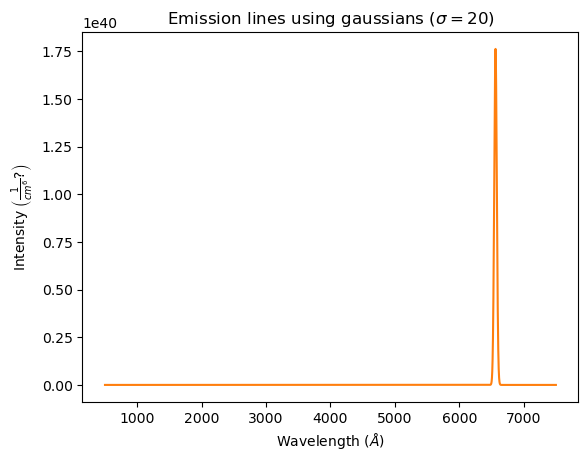

In [32]:
import matplotlib.pyplot as plt
x_vals = line_sums_array[:,1].astype(float)
y_vals = line_sums_array[:,0].astype(float)
print(y_vals)
def gaussian(x, area, mean, std): #this should already exist look these things up!!!!
    return area * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))
sigma = 20 #arbitrary value for now
wavelength = (min(x_vals)-100, max(x_vals)+100, 3000)
#how do we determine sigma
#how do we set this up so we can add gaussians together
y_tot = np.zeros(70000) #array for storing y values
x = np.linspace(500,7500, 70000) #wavelength range
for i in range(len(x_vals)):
    y = gaussian(x, y_vals[i], x_vals[i], sigma) # applies the gaussian for one peak over x array to obtain y values
    center_val = gaussian(x_vals[i], y_vals[i], x_vals[i], sigma)
    print(x_vals[i])
    #print(center_val/y_vals[i[0]])
    y_tot += y
    #print(int(np.round(x_vals[i[0]])))
    #print(x_vals[i[0]], y_tot[int(np.round(x_vals[i[0]]))-500]) #prints wavelength and gaussian peak at that point
plt.plot(x,y_tot, marker = " ", color = "tab:orange", linestyle = "-")
plt.yscale("linear")
#plt.ylim(0,10**-31)
#plt.xlim(1050,1150)
plt.xlabel(r"Wavelength $(\AA)$")
plt.ylabel(r"Intensity $\left(\frac{1}{cm^6}?\right)$")
plt.title(r"Emission lines using gaussians ($\sigma = 20$)")
#plt.savefig("Gaussian_emission_plot")
plt.show()

12.171087046255657


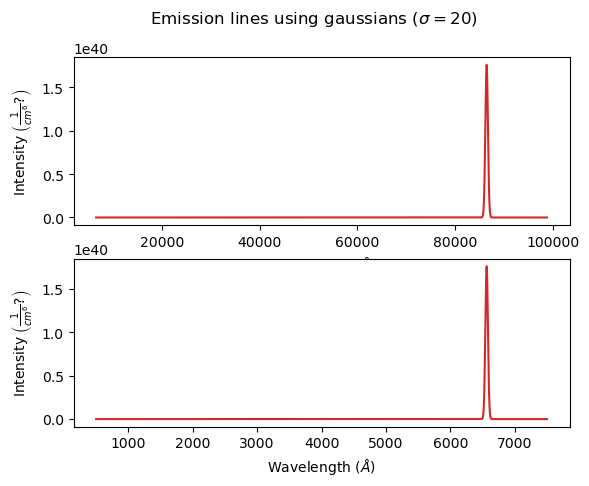

In [28]:

print(ds.current_redshift)
x_rshift = x * (ds.current_redshift+1)
fig, axs = plt.subplots(2,1)
axs[0].plot(x_rshift,y_tot, marker = " ", color = "tab:red", linestyle = "-")
axs[1].plot(x,y_tot, marker = " ", color = "tab:red", linestyle = "-")

axs[0].set_yscale("linear")
axs[1].set_yscale("linear")

#plt.ylim(0,10**-31)
#plt.xlim(1050,1150)
for ax in axs.flat:
    ax.set(xlabel = r"Wavelength $(\AA)$", ylabel = r"Intensity $\left(\frac{1}{cm^6}?\right)$")
fig.suptitle(r"Emission lines using gaussians ($\sigma = 20$)")
#plt.savefig("Gaussian_emission_plot")
### Don't know how this works
plt.show()
print(axs.flat)

In [33]:
fline_sums = []  # Start with an empty Python list
for line in enumerate(lines):
    wave_unmod = line[1].split("_")[-1]
    wavelength = wave_unmod[:-1]
    luminosities = sp.quantities.total_quantity(("gas", f"flux_{line[1]}"))
    fline_sums.append((float(luminosities), float(wavelength), f"flux_{line[1]}"))  # Append the tuple
line_sums_array = np.array(fline_sums)  # Convert to a NumPy array if needed
print(line_sums_array)

[['2.564674876108311e-12' '6562.8' 'flux_H1_6562.80A']
 ['1.3940897903161756e-19' '1304.86' 'flux_O1_1304.86A']
 ['2.4500380160387683e-17' '6300.3' 'flux_O1_6300.30A']
 ['2.981369016682573e-17' '3728.8' 'flux_O2_3728.80A']
 ['6.370435576639567e-17' '3726.1' 'flux_O2_3726.10A']
 ['4.372349587192578e-18' '1660.81' 'flux_O3_1660.81A']
 ['1.2804526282526254e-17' '1666.15' 'flux_O3_1666.15A']
 ['4.551952380665802e-18' '4363.21' 'flux_O3_4363.21A']
 ['3.770858158709858e-17' '4958.91' 'flux_O3_4958.91A']
 ['1.1250700446443198e-16' '5006.84' 'flux_O3_5006.84A']
 ['1.3684408367537368e-15' '1640.41' 'flux_He2_1640.41A']
 ['1.4029925270035427e-18' '1335.66' 'flux_C2_1335.66A']
 ['5.925478602475138e-17' '1906.68' 'flux_C3_1906.68A']
 ['5.176654226447218e-17' '1908.73' 'flux_C3_1908.73A']
 ['9.404971379420418e-26' '1549.0' 'flux_C4_1549.00A']
 ['1.0738302867575632e-16' '2795.53' 'flux_Mg2_2795.53A']
 ['5.423816446142674e-17' '2802.71' 'flux_Mg2_2802.71A']
 ['3.1155664501052118e-18' '3868.76' 'flux_

[2.56467488e-12 1.39408979e-19 2.45003802e-17 2.98136902e-17
 6.37043558e-17 4.37234959e-18 1.28045263e-17 4.55195238e-18
 3.77085816e-17 1.12507004e-16 1.36844084e-15 1.40299253e-18
 5.92547860e-17 5.17665423e-17 9.40497138e-26 1.07383029e-16
 5.42381645e-17 3.11556645e-18 9.45622368e-19 5.06016786e-23
 2.52289988e-23 1.27662874e-20 5.64328614e-18 1.39879702e-17
 2.66448284e-17]
1304.86
6300.3
3728.8
3726.1
1660.81
1666.15
4363.21
4958.91
5006.84
1640.41
1335.66
1906.68
1908.73
1549.0
2795.53
2802.71
3868.76
3967.47
1238.82
1242.8
1486.5
1749.67
6716.44
6730.82


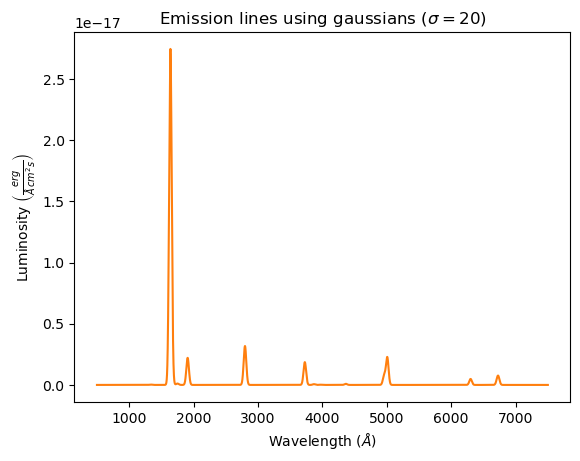

12.171087046255657


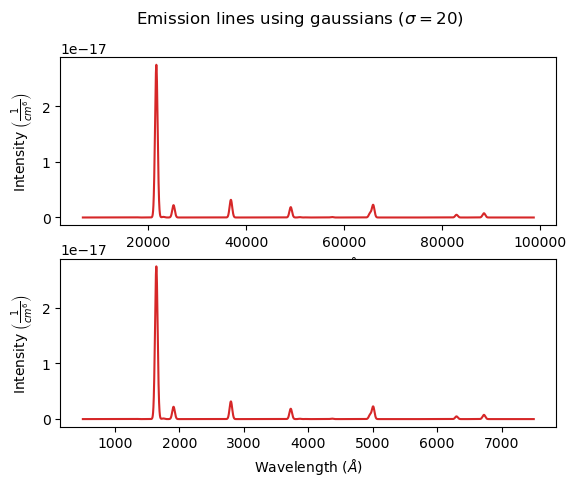

In [44]:
import matplotlib.pyplot as plt
x_vals = line_sums_array[:,1].astype(float)
y_vals = line_sums_array[:,0].astype(float)
print(y_vals)
def gaussian(x, area, mean, std): #this should already exist look these things up!!!!
    return area * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))
sigma = 20 #arbitrary value for now
wavelength = (min(x_vals)-100, max(x_vals)+100, 3000)
#how do we determine sigma
#how do we set this up so we can add gaussians together
y_tot = np.zeros(70000) #array for storing y values
x = np.linspace(500,7500, 70000) #wavelength range
for i in range(len(x_vals)-1):
    y = gaussian(x, y_vals[i+1], x_vals[i+1], sigma) # applies the gaussian for one peak over x array to obtain y values
    center_val = gaussian(x_vals[i+1], y_vals[i+1], x_vals[i+1], sigma)
    print(x_vals[i+1])
    #print(center_val/y_vals[i[0]])
    y_tot += y
    #print(int(np.round(x_vals[i[0]])))
    #print(x_vals[i[0]], y_tot[int(np.round(x_vals[i[0]]))-500]) #prints wavelength and gaussian peak at that point
plt.plot(x,y_tot, marker = " ", color = "tab:orange", linestyle = "-")
plt.yscale("linear")
#plt.ylim(0,10**-31)
#plt.xlim(1050,1150)
plt.xlabel(r"Wavelength $(\AA)$")
plt.ylabel(r"Luminosity $\left(\frac{erg}{\AA^{} cm^2 s }\right)$")
plt.title(r"Emission lines using gaussians ($\sigma = 20$)")
#plt.savefig("Gaussian_emission_plot")
plt.show()
print(ds.current_redshift)
x_rshift = x * (ds.current_redshift+1)
fig, axs = plt.subplots(2,1)
axs[0].plot(x_rshift,y_tot, marker = " ", color = "tab:red", linestyle = "-")
axs[1].plot(x,y_tot, marker = " ", color = "tab:red", linestyle = "-")

axs[0].set_yscale("linear")
axs[1].set_yscale("linear")

for ax in axs.flat:
    ax.set(xlabel = r"Wavelength $(\AA)$", ylabel = r"Intensity $\left(\frac{1}{cm^6}\right)$")
fig.suptitle(r"Emission lines using gaussians ($\sigma = 20$)")
#plt.savefig("Gaussian_emission_plot")
plt.show()